# Hi Lucas.
The first cell below is just a general test if the installation of the package went through. Don't worry about the details of the code, I will step you through the relevant parts in the notebook.

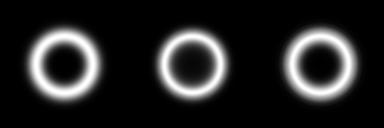

In [5]:
using SLMTools

# Generate an input grid and corresponding output grid
N = 128
L0 = natlat((N,N))
# Generate an input beam and target output beam
inputBeam = lfGaussian(Intensity, L0, 1.0)
targetBeam = lfRing(Intensity, L0, 2.5, 0.5)

# Use optimal transport to find an SLM phase to make an approximate output beam
phiOT = otPhase(inputBeam,targetBeam, 0.001)

# Refine the above phase using the Gerchberg-Saxton algorithm.
phiGS = gs(inputBeam,targetBeam,100,phiOT)

# View the resulting output beams
outputOT = square(sft(sqrt(inputBeam) * phiOT))
outputGS = square(sft(sqrt(inputBeam) * phiGS))
look(targetBeam,outputOT,outputGS)

# New code
Below is the new code that I wrote, which will be the starting point for our experiments. Feel free to edit the code right in this document, but make sure to make a copy of the original code for your own reference.

First, open the following document:
https://arxiv.org/pdf/2506.11352

Take a look at Algorithm 3 at page 84. This is the algorithm proposed in "Lightspeed Computation of Optimal Transport Distances" (https://arxiv.org/abs/1306.0895), or at least how I understood it. **Please let me know if you think I got some part of it wrong**

Then take a look at Algorithm 4, which is Algorithm 3 but it is using this convolution trick described in my thesis to reduce the memory and time scaling.The inputs to this algorithm are the marginals $\mu$ and $\nu$ along with the regualrization parameter $\epsilon$, and it outputs the optimal dual variables $u$ and $v$. 

Finally, the Algorithm 5 takes in dual variables $u$ and $v$ as inputs and computes the Monge map,($\nabla \phi_x$, $\nabla \phi_y$) using a similar convolutionn trick.

If this doesn't make sense, try to skim through the chapter 4.6 in the thesis, and we can talk about it together! Once you read through those take a look at the Appendix B, page 115, and try to skim through the code that implements the Algrorithms 4 and 5. This pseudocode used to be the implementation in SLMTools, but now we upgraded it slightly to make it work in arbitrary dimension, and avoid some numerical issues.

Below is the current implementation that we have in the package. I will describe here what individual functions do -- sorry for the sparse documentation, it's at a very experimental stage :)

* `toDim` -- utility function that reshapes a 1-dimensional array v into an n-dimensional array, where its elements are spread along dimension d, and all other dimensions are of size 1.
* `SinkhornConvN` -- this is Algorithm 4 that works with input of arbitrary dimension. Variables `U` and `V` are marginal constraints, `ϵ` is the regularization parameter, `max_iter` is the number of iterations, `every` controls how often to track the loss. 
* `SinkhornIterBase` -- this is the iteration part of Algorithm 4.
* `dualToGradients` -- Algorithm 5
* `otQuickPhase` a wrapper for SLMTools to put the pipeline together.

Take a quick look at these, and scroll to the end of this document

In [2]:
using LinearAlgebra
using Plots

In [ ]:
"""Fast 2D Sinkhorn algorithm implementation using convolution operations."""
function toDim(v, d::Int, n::Int)
    reshape(v, ((i == d ? length(v) : 1) for i = 1:n)...)
end

function SinkhornIterBase!(u::Array{T1, N}, v::Array{T1, N},U::Array{T2, N}, V::Array{T3, N},FAu::Array{T4, N},FAv::Array{T4, N}) where {T1<:Real,T2<:Real,T3<:Real,T4<:Number,N}
        # row constraint
        row_sum = real.(isft(sft(u).*FAu))
        v[:] = (V .* safeInverse.(row_sum))[:]
        v .*= safeInverse(sum(v))
        
        # col constraint
        col_sum = real.(isft(sft(v).*FAv))
        u[:] = (U .* safeInverse.(col_sum))[:]
        u .*= safeInverse(sum(u))
end

function SinkhornConvN(U::Array{T1, N}, V::Array{T2, N}, ϵ::Real, max_iter::Integer; every::Union{Nothing,Integer}=nothing) where {T1<:Real,T2<:Real,N}
    # initialization
    u = fill(1/prod(size(U)),size(U))
    v = Array{T2}(undef,size(V))

    # loss tracking
    loss = []
    prev = copy(u) 
    
    # create convolution matrices
    keru = r2(natlat(size(u)))
    kerv = r2(natlat(size(v)))
    keru ./= keru[1]    # keru attains its maximum value at its first point. Faster than maximum(keru). 
    kerv ./= kerv[1]
    Au = exp.(-keru / ϵ)
    Av = exp.(-kerv / ϵ)
    FAu = sft(Au)
    FAv = sft(Av)

    for i in range(1, max_iter)
        SinkhornIterBase!(u, v, U, V, FAu, FAv)
        
        # log loss
        if !isnothing(every) && mod(i,every)==0
            # Computes loss: \sum_{i,j} u_i v_j \exp(C_{ij}/\epsilon) - \sum_i \log u_i - \sum_j \log v_j
            # using convolution K .* v → conv_v
            conv_v = real.(isft(sft(v) .* FAv))
            push!(loss, sum(u .* conv_v) - sum(log.(u)) - sum(log.(v)))
        end
    end
    
    # row constraint
    row_sum = real.(isft(sft(u).*FAu))
    v = V .* safeInverse.(row_sum)
    
    # col constraint
    col_sum = real.(isft(sft(v).*FAv))
    u = U .* safeInverse.(col_sum)
    
    return u, v, loss
end

"""Computes gradient of transport potential from Sinkhorn dual variables."""
function dualToGradients(u::Array{T1,N}, v::Array{T1,N}, U::Array{T2,N}, LV::Lattice{N}, ϵ::Real) where {T1<:Real, T2<:Real,N}
    
    # create convolution matrix
    kerv = r2(natlat(size(v)))
    kerv ./= kerv[1]
    Av = exp.(-kerv / ϵ)
    FAv = sft(Av)
    
    # moment calculation
    gradphi = zeros(size(u)...,N)

    # convolution step
    uscale = u .* safeInverse.(U)
    for i=1:N
        CI = CartesianIndices((size(u)...,i:i))
        gradphi[CI] = uscale .* real.(isft(sft( v .* toDim(LV[i],i,N) ).*FAv))
    end
    
    return gradphi
end

"""Fast phase retrieval using Sinkhorn algorithm with convolution operations."""
function otQuickPhase(g2::LF{Intensity,T,N}, G2::LF{Intensity,T,N}, ϵ::Real, max_iter::Integer) where {T<:Real,N}
    u, v, loss = SinkhornConvN(g2.data, G2.data, ϵ, max_iter; every=1)
    vf = dualToGradients(u, v, g2.data, G2.L,  ϵ)
    Φ = scalarPotentialN(vf, g2.L)
    return LF{RealPhase}(Φ, g2.L), loss
end

otQuickPhase

# Qucik Check

Notice below that the loss becomes crazy as I decrease the epsilon parameter -- our goal is to push the numerical stability as far as we can! 

**Note:** take a look carefully how i implemented "loss" -- i am not sure if this is the best way to do it, and if it's the right value to track

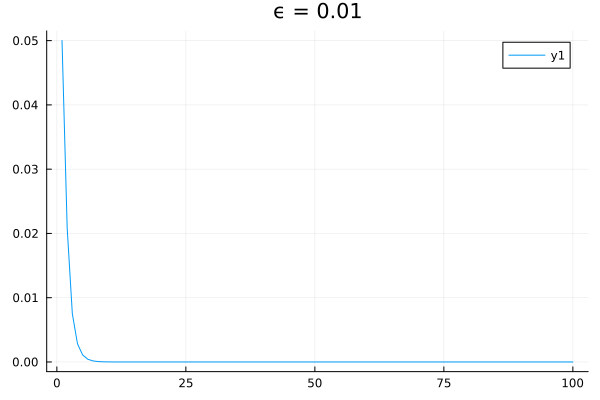

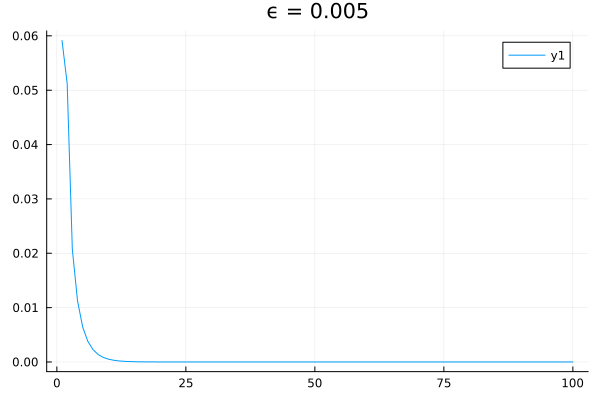

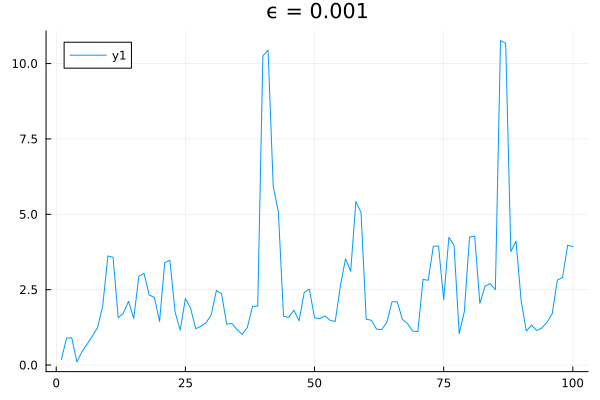

In [19]:
# Use optimal transport to find an SLM phase to make an approximate output beam
for ϵ in [0.01, 0.005, 0.001]
    phiOT, loss = otQuickPhase(inputBeam,targetBeam, ϵ, 100)
    display(plot(loss, title="ϵ = $ϵ"))
end

# TODO (1): Initialization

Here is the first thing that would be super interesting (and relatively simple) to try. Read through this paper by Cuturi and Thornton:
https://arxiv.org/abs/2206.07630

Their Algorithm 1 on page 2 is basically what we have but there are some differences in how they do safe division, and they also seem to operate in the log space. I want to understand the relationship between their algorithm and then one i have implemented above. Also, I would want to benchmark and see which algorithm is more numerically stable. 

The juice of the paper is that correct initialization to Sinkhorn can save a huge amount of iterations (see Table 1). I want to implement their gaussian initialization and see how much better it is!



# TODO (2): Convolution implementation

I implemented gaussian convolution using FFT approach -- this is probably not the best approach. I found the following review article, which looks like an excellent source to figure out what is the best way to compute a Gaussian convolution:

Pascal Getreuer. A Survey of Gaussian Convolution Algorithms. Image Processing On Line,
3:286–310, 2013. https://doi.org/10.5201/ipol.2013.87.

Would be amazing to benchmark couple of convolution approaches and see what is the best

# TODO (3): Scheduling epsilon decrease
You mentioned this super interesting idea of starting at a high value of epsilon and then slowly reducing it during iterations. I think it's a great idea and we should def try it!